/tmp/ipykernel_3847138/531043620.py:197: RuntimeWarning: invalid value encountered in scalar divide
  1 + 1 / K - (1 - 1 / K) * ((r / vMstress) ** 3)
/tmp/ipykernel_3847138/531043620.py:185: RuntimeWarning: invalid value encountered in sqrt
  sqrt_term = np.sqrt((alpha * (d + p_a * np.tan(beta)))**2 - (p - p_a)**2)


Triaxial test: Tridimensional
final normal strain in z direction:  0.0003840000000000002
final normal stress in z direction:  -8.328514664249007e-15 Pa
final von Mises stress:  192.0 Pa
final hydrostatic pressure:  64.00000000000001 Pa
[            nan -0.00000000e+00 -0.00000000e+00 -0.00000000e+00
  6.56342939e-03  3.34734899e-01  6.62906369e-01  9.91077838e-01
  1.31924931e+00  1.64742078e+00  1.97559225e+00  2.30376372e+00
  2.63193519e+00  2.96010666e+00  3.28827813e+00  3.61644959e+00
  3.94462106e+00  4.27279253e+00  4.60096400e+00  4.92913547e+00
  5.25730694e+00  5.58547841e+00  5.91364988e+00  6.24182135e+00
  6.56999282e+00  6.89816429e+00  7.22633576e+00  7.55450723e+00
  7.88267870e+00  8.21085017e+00  8.53902164e+00  8.86719311e+00
  9.19536458e+00  9.52353605e+00  9.85170752e+00  1.01798790e+01
  1.05080505e+01  1.08362219e+01  1.11643934e+01  1.14925649e+01
  1.18207363e+01  1.21489078e+01  1.24770793e+01  1.28052507e+01
  1.31334222e+01  1.34615937e+01  1.37897652e+01 

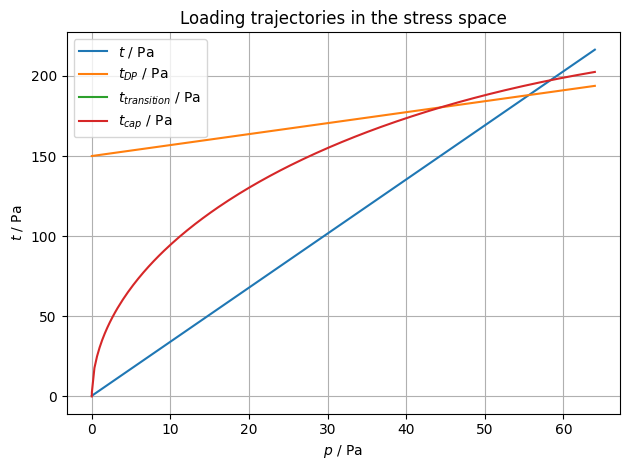

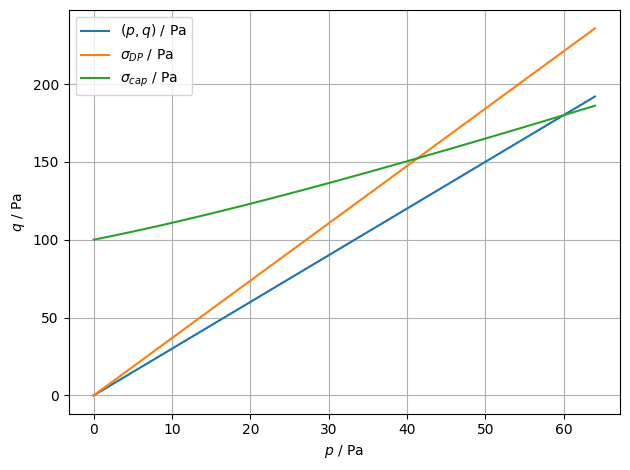

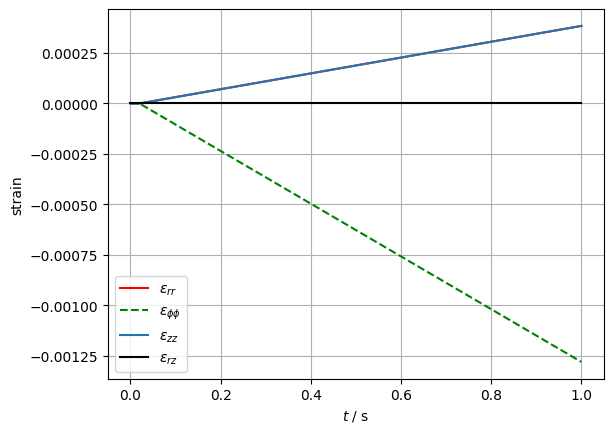

In [90]:
import os
import sys
sys.path.append("/mofem_install/spack/opt/spack/linux-ubuntu20.04-x86_64/gcc-9.4.0/tfel-4.0.0-jjcwdu6cbil5dzqzjhjekn3jdzo3e6gc/lib/python3.11/site-packages")
import matplotlib.pyplot as plt
import numpy as np
import mtest

m = mtest.MTest()
mtest.setVerboseMode(mtest.VerboseLevel.VERBOSE_QUIET)
m.setMaximumNumberOfSubSteps(20)
m.setModellingHypothesis("Tridimensional")

model = "DruckerPragerCap"

controls = ["stress", "strain"]

# Set  material model implementation and path
lib_path = "/mofem_install/jupyter/thomas/mfront_interface/src/libBehaviour.so"
control = controls[0]

m.setBehaviour("generic", lib_path, model)

# Material constants

# @Parameter d    = 150;
# @Parameter beta = 0.6;
# @Parameter pa   = -10;
# @Parameter pb   = -75;

E = 150e3
nu = 0.3
d = 150
beta = 0.6
pa = -100
pb = -200

R = (pa - pb) / (d - pa * np.tan(beta))

# Loading programme
tMax = 1.0  # s , total time
nTime = 200
ltime = np.linspace(0.0, tMax, nTime)

p_con =  0 # confining pressure
p_axi = 192

e_con = p_con * (1 - 2 * nu) / E
e_axi = 16 * e_con

# Environment parameters
m.setExternalStateVariable("Temperature", 293.15)

# Material parameters
m.setMaterialProperty("YoungModulus", E)
m.setMaterialProperty("PoissonRatio", nu)
m.setMaterialProperty("d", d)
m.setMaterialProperty("beta", beta)
m.setMaterialProperty("pa", pa)
m.setMaterialProperty("pb", pb)

# Set initial stress and strain state
eps_init = [-e_con, -e_con, -e_con, 0.0, 0.0, 0.0]
sig_init = [-p_con, -p_con, -p_con, 0.0, 0.0, 0.0]
m.setStress(sig_init)
m.setStrain(eps_init)

m.setImposedStress("SXX", {0: -p_con, 0.02: -p_con, 1.0: -p_con})
m.setImposedStress("SYY", {0: -p_con, 0.02: -p_con, 1.0: -p_con})

if control == "stress":
    m.setImposedStress("SZZ", {0: -p_con, 0.02: -p_con, 1.0: -p_axi})
if control == "strain":
    raise NotImplementedError("Not implemented")


s = mtest.MTestCurrentState()
wk = mtest.MTestWorkSpace()
m.completeInitialisation()
m.initializeCurrentState(s)
m.initializeWorkSpace(wk)

# initialize output lists
pCurve = np.array([np.NaN])
qCurve = np.array([np.NaN])
eVCurve = np.array([0.0])
eQCurve = np.array([0.0])
strains = np.empty(shape=(4, nTime))
stresses = np.empty(shape=(4, nTime))
dpCurve = np.array([0.0])
capCurve = np.array([0.0])
tCurve = np.array([np.NaN])
tdpCurve = np.array([np.NaN])
ttCurve = np.array([np.NaN])
tcapCurve = np.array([np.NaN])

# stresses[0][:] = sig_init
for k in range(4):
    strains[k][0] = eps_init[k]

for k in range(4):
    stresses[k][0] = sig_init[k]

# initialize yield functions
nPoints = 1000
pRange = np.empty(shape=(nTime, nPoints))

# run sim
for i in range(nTime - 1):
    m.execute(s, wk, ltime[i], ltime[i + 1])
    # output variables:
    
    s1_0 = - s.s1[0]
    s1_1 = - s.s1[1]
    s1_2 = - s.s1[2]
    s1_3 = - s.s1[3]
    s1_4 = - s.s1[4]
    s1_5 = - s.s1[5]
    
    
    pressure = (s1_0 + s1_1 + s1_2) / 3
    
    dev_stress = np.array([
        s1_0 - pressure,
        s1_1 - pressure,
        s1_2 - pressure,
        s1_3,  # s_xy
        s1_4,  # s_xz
        s1_5   # s_yz
    ])
    
    vMstress = np.sqrt(
        0.5
        * (
            (s1_0 - s1_1) ** 2
            + (s1_1 - s1_2) ** 2
            + (s1_2 - s1_0) ** 2
            + 3 * s1_3 ** 2
        )
    )
    epsilonV = s.e1[0] + s.e1[1] + s.e1[2]
    argument = (
        2
        * (
            s.e1[0] ** 2
            + s.e1[1] ** 2
            + s.e1[2] ** 2
            - epsilonV**2 / 3
            + 2 * s.e1[3] ** 2
        )
        / 3
    )
    vMstrain = np.sqrt(max(argument, 0))

    pCurve = np.append(pCurve, pressure)
    qCurve = np.append(qCurve, vMstress)
    eVCurve = np.append(eVCurve, epsilonV)
    eQCurve = np.append(eQCurve, vMstrain)
    
    # calculate for the stress surfaces? Don't quite understand
    
    J2 = (1/6) * (
        (s1_0 - s1_1) ** 2 +
        (s1_1 - s1_2) ** 2 +
        (s1_2 - s1_0) ** 2
    ) + (1/3) * (
        s1_3 ** 2 + s1_4 ** 2 + s1_5 ** 2
    )
        # Third invariant of deviatoric stress (r)
    S_dev = dev_stress[:3]  # Deviatoric normal stress components
    r = ((9/2) * np.dot(S_dev, S_dev)) ** (1/3)
    K = 0.8
    alpha = 0.03
    
    
    
    d_ = d
    p_b = -pb
    p_a = -pa
    R_ = (p_a - p_b) / (- d_ - p_a * np.tan(beta))
    

    
    def transition_surface(p, R, alpha, beta, d, p_a):
        constant_term = (1 - alpha / np.cos(beta)) * (d + p_a * np.tan(beta))
        sqrt_term = np.sqrt((alpha * (d + p_a * np.tan(beta)))**2 - (p - p_a)**2)
        t = constant_term + sqrt_term
        return t
    
    def cap_surface(p, R, alpha, beta, d, p_a):
        sqrt_term = np.sqrt(np.maximum((R * (d + p_a * np.tan(beta)))**2 - (p - p_a)**2, 0))
        scale_factor = (1 + alpha - alpha / np.cos(beta)) / R
        t = scale_factor * sqrt_term
        return t
    
    
    t = (vMstress / 2) * (
        1 + 1 / K - (1 - 1 / K) * ((r / vMstress) ** 3)
    )
    t_dp = pressure * np.tan(beta) + d_
    tt = transition_surface(pressure,R_,alpha,beta,d_,p_a)
    tcap = cap_surface(pressure,R_,alpha,beta,d_,p_a)
    
    tCurve = np.append(tCurve, t)
    tdpCurve = np.append(tdpCurve, t_dp)
    ttCurve = np.append(ttCurve, tt)
    tcapCurve = np.append(tcapCurve, tcap)
    
    
    sig_eq_dp = vMstress + np.tan(beta) * pressure
    sig_eq_cap = np.sqrt((pressure - pa)**2+(R*vMstress)**2)
    
    dpCurve = np.append(dpCurve, sig_eq_dp)
    capCurve = np.append(capCurve, sig_eq_cap)
    

    for k in range(4):
        strains[k][i + 1] = s.e1[k]

    for k in range(4):
        stresses[k][i + 1] = s.s1[k]

# print some final values
print(f"Triaxial test: Tridimensional")
print("final normal strain in z direction: ", s.e1[1])
print("final normal stress in z direction: ", s.s1[1], "Pa")
print("final von Mises stress: ", vMstress, "Pa")
print("final hydrostatic pressure: ", pressure, "Pa")
result_dir = f"/mofem_install/jupyter/thomas/mfront_interface/results/DP_sig_1_{p_axi}/"
os.makedirs(result_dir,exist_ok=True)

fig, ax = plt.subplots()
ax.set_title("Loading trajectories in the stress space")
print(pCurve)

ax.plot(pCurve, tCurve, label="$t$ / Pa")
ax.plot(pCurve, tdpCurve, label="$t_{DP}$ / Pa")
ax.plot(pCurve, ttCurve, label="$t_{transition}$ / Pa")
ax.plot(pCurve, tcapCurve, label="$t_{cap}$ / Pa")


ax.set_xlabel("$p$ / Pa")
ax.set_ylabel("$t$ / Pa")
ax.grid()
ax.legend()
fig.tight_layout()
fig.savefig(f"{result_dir}/Triaxial_YieldSurfacet.pdf")

fig, ax = plt.subplots()
ax.plot(pCurve, qCurve, label="$(p,q)$ / Pa")
ax.plot(pCurve, dpCurve, label="$\sigma_{DP}$ / Pa")
ax.plot(pCurve, capCurve, label="$\sigma_{cap}$ / Pa")
plt.quiver(
    pCurve[:-1],
    qCurve[:-1],
    pCurve[1:] - pCurve[:-1],
    qCurve[1:] - qCurve[:-1],
    scale_units="xy",
    angles="xy",
    scale=1,
)
ax.set_xlabel("$p$ / Pa")
ax.set_ylabel("$q$ / Pa")
ax.grid()
ax.legend()
fig.tight_layout()
fig.savefig(f"{result_dir}/Triaxial_YieldSurfaceq.pdf")



fig, ax = plt.subplots()
ax.plot(ltime, strains[0][:], color="red", label=r"$\epsilon_{rr}$")
ax.plot(ltime, strains[2][:], "--", color="green", label=r"$\epsilon_{\phi\phi}$")
ax.plot(ltime, strains[1][:], label=r"$\epsilon_{zz}$")
ax.plot(ltime, strains[3][:], color="black", label=r"$\epsilon_{rz}$")
ax.set_xlabel("$t$ / s")
ax.set_ylabel("strain")
ax.grid()
ax.legend(loc="lower left")
fig.savefig(f"{result_dir}/Triaxial_Strains.pdf")


# fig, ax = plt.subplots()
# ax.plot(ltime, phiCurve - phi0, label=r"$\phi-\phi_0$")
# ax.plot(ltime, eVCurve, label=r"$\epsilon_{V}$")
# ax.plot(ltime, lpCurve, label=r"$\epsilon_{eq}$")
# ax.set_xlabel("$t$ / s")
# ax.set_ylabel(" ")
# ax.grid()
# ax.legend()

# plt.show()
